# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [183]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [184]:
region_one = pd.read_csv('/datasets/geo_data_0.csv')

In [185]:
region_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [186]:
region_two = pd.read_csv('/datasets/geo_data_1.csv')

In [187]:
region_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [188]:
region_three = pd.read_csv('/datasets/geo_data_2.csv')

In [189]:
region_three.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [190]:
region_one.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [191]:
region_two.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [192]:
region_three.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [193]:
# Удаляем строки с дублированными данными в колонке id
regions = [region_one, region_two, region_three]
for region in regions:
    region.drop(region.query('id.duplicated() == True').index, inplace=True)

In [194]:
region_one['id'].duplicated().sum()

0

In [195]:
region_two['id'].duplicated().sum()

0

In [196]:
region_three['id'].duplicated().sum()

0

In [197]:
# Выделяем целевые и независимые признаки в регионах
# Для выборок независимых признаков также удаляем колонку id, т.к. данные в ней будут мешать обучению моделей.
region_one_A = region_one.drop(['product','id'], axis=1)
region_one_B = region_one['product']
region_two_A = region_two.drop(['product','id'], axis=1)
region_two_B = region_two['product']
region_three_A = region_three.drop(['product','id'], axis=1)
region_three_B = region_three['product']

###### Вывод

- Чтобы избежать ошибок, в датасетах были удалены строки с дублирующимися id.
- Для каждого региона были выделены независимые и целевые признаки

## Обучение и проверка модели

In [198]:
# Делим данные трёх регионов на обучающие и валидационные выборки
# Для удобства регион №1 будет называться north, а регионы №2 и №3 соответственно middle и south
north_A_train, north_A_valid, north_B_train, north_B_valid = train_test_split(region_one_A, region_one_B, test_size=0.25) # отделите 25% данных для валидационной выборки
middle_A_train, middle_A_valid, middle_B_train, middle_B_valid = train_test_split(region_two_A, region_two_B, test_size=0.25) # отделите 25% данных для валидационной выборки
south_A_train, south_A_valid, south_B_train, south_B_valid = train_test_split(region_three_A, region_three_B, test_size=0.25) # отделите 25% данных для валидационной выборки

In [199]:
# создаем нашу модель линейной регрессии
model = LinearRegression()

In [200]:
# обучаем модель на данных региона №1
model.fit(north_A_train, north_B_train)
north_predicted = model.predict(north_A_valid)
mse_north = mean_squared_error(north_B_valid, north_predicted)
rmse_north = mse_north**0.5
north_mean = north_predicted.mean()
print(f'Регион №1. Средний запас предсказанного сырья: {north_mean}, RMSE = {rmse_north}')

Регион №1. Средний запас предсказанного сырья: 92.48550252860535, RMSE = 37.682515408574076


In [201]:
# обучаем модель на данных региона №2
model.fit(middle_A_train, middle_B_train)
middle_predicted = model.predict(middle_A_valid)
mse_middle = mean_squared_error(middle_B_valid, middle_predicted)
rmse_middle = mse_middle**0.5
middle_mean = middle_predicted.mean()
print(f'Регион №2. Средний запас предсказанного сырья: {middle_mean}, RMSE = {rmse_middle}')

Регион №2. Средний запас предсказанного сырья: 68.68272756165844, RMSE = 0.8916819868937543


In [202]:
# обучаем модель на данных региона №3
model.fit(south_A_train, south_B_train)
south_predicted = model.predict(south_A_valid)
mse_south = mean_squared_error(south_B_valid, south_predicted)
rmse_south = mse_south**0.5
south_mean = south_predicted.mean()
print(f'Регион №3. Средний запас предсказанного сырья: {south_mean}, RMSE = {rmse_south}')

Регион №3. Средний запас предсказанного сырья: 94.67826896996021, RMSE = 40.04535578503351


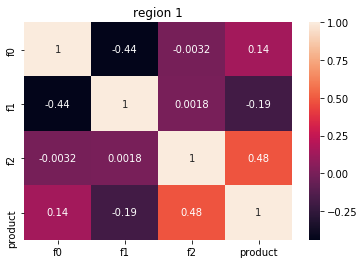

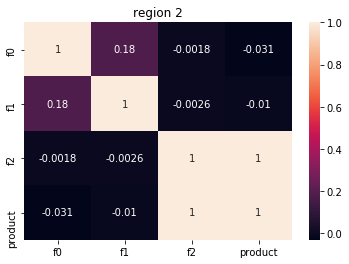

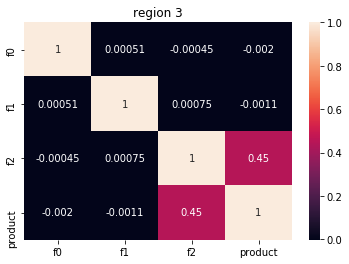

In [203]:
for i in range(len(regions)):
    ax = plt.axes()
    sns.heatmap(regions[i].corr(), annot = True)
    ax.set_title('region ' + str(i+1))
    plt.show()

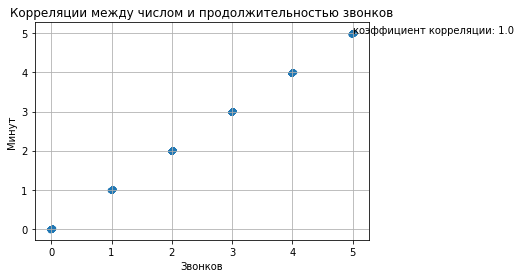

In [204]:
region_two_A.plot(x='f2', y='f2', kind='scatter', grid=True) 
plt.text(5, 5, 'коэффициент корреляции: ' + str(round(region_two_A['f2'].corr(region_two_A['f2']), 2)))
plt.title("Корреляции между числом и продолжительностью звонков")
plt.ylabel("Минут")
plt.xlabel("Звонков")
plt.show()

###### Вывод
- Мы разделили данные каждого региона на обучающую и валидационную выборки;
- Обучили модель линейной регрессии на тренировочных данных каждого региона;
- Посчитали среднее количество предсказанных запасов в каждом регионе, и посчитали среднеквадратическую ошибку;
- В регионе №1. Средний запас предсказанного сырья: 92.516 тыс.баррелей, RMSE = 37.7387;
- В регионе №2. Средний запас предсказанного сырья: 68.966 тыс.баррелей, RMSE = 0.8907;
- В регионе №3. Средний запас предсказанного сырья: 95.0019 тыс.баррелей, RMSE = 39.94007;
- Для проверки корреляции признаков мы построили тепловые карты данных для каждого региона. Удалось обнаружить высокую корреляцию между признако f2 и целевым признаком в регионе №2, потому среднеквадратическая ошибка в этом регионе меньше единицы.

## Подготовка к расчёту прибыли

In [205]:
# Сохраняем ключевые значения для расчетов
REGIONAL_BUDGET = 10_000_000_000 # Бюджет на разработку скважин в регионе
ONE_BARREL_INCOME = 450  # Доход с одного барреля сырья 
INCOME_PER_UNIT = 450_000 # Доход с каждой единицы продукта 
MINES_COUNT = 200 # Количество лучших шахт для расчета прибыли

In [206]:
# Рассчитываем достаточный объём сырья для безубыточной разработки новой скважины
REGIONAL_DEVELOPMENT = REGIONAL_BUDGET/INCOME_PER_UNIT
STAPLE_VOLUME = REGIONAL_DEVELOPMENT / MINES_COUNT
round(STAPLE_VOLUME, 2)

111.11

In [207]:
# Сравнение средних запасов предсказанного сырья в регионах по сравнению с объёмом достаточным для безубыточной разработки
means = [north_mean, middle_mean, south_mean]

In [208]:
print('Для безубыточной разработки необходимо чтобы одна скважина добывала не менее:', round(STAPLE_VOLUME + 1), 'тыс. баррелей \n')
# Рассчитаем средний запас по каждому региону

print('В среднем первый регион добывает:', round(region_one['product'].mean()), 'тыс. баррелей')
print('В среднем второй регион добывает:', round(region_two['product'].mean()), 'тыс. баррелей')
print('В среднем третий регион добывает:', round(region_three['product'].mean()), 'тыс. баррелей')
print(REGIONAL_BUDGET)

Для безубыточной разработки необходимо чтобы одна скважина добывала не менее: 112 тыс. баррелей 

В среднем первый регион добывает: 92 тыс. баррелей
В среднем второй регион добывает: 69 тыс. баррелей
В среднем третий регион добывает: 95 тыс. баррелей
10000000000


###### Вывод
 - При таком раскладе у нас не очень утешительный прогноз, действительно одна скважина должна добывать не менее 112 тыс. баррелей, а средние значения по каждому из регионов меньше. Т.е мы должны выбирать только самые лучшие месторождения и не имеем право на сильное отклонение

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [209]:
# Функция для расчета прибыли по выбранным скважинам и предсказаниям модели
def profit(target, predictions):
    target = pd.Series(target).reset_index(drop=True)
    predictions = pd.Series(predictions).reset_index(drop=True)
    predictions_s = predictions.sort_values(ascending=False)[:MINES_COUNT].index
    selected = target[predictions_s]
    profit = selected.sum() * INCOME_PER_UNIT - REGIONAL_BUDGET
    return round(profit, 2)

In [210]:
profit(north_B_valid, north_predicted)

3384963940.12

In [211]:
profit(middle_B_valid, middle_predicted)

2415086696.68

In [212]:
profit(south_B_valid, south_predicted)

2357513643.43

## Расчёт прибыли и рисков 

In [213]:
def bootstrap(target, probabilities, iterations, sample_size):
    state = np.random.RandomState(12345)
    values = []
    for i in range(iterations):
        target_subsample = target.sample(n=sample_size, random_state=state, replace=True)
        probs_subsample = probabilities[target_subsample.index]
        values.append(profit(target_subsample, probs_subsample))

    values = pd.Series(values)
    mean = values.mean()
    risk = (values < 0).mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, loc=values.mean(), scale=values.sem())
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    quantile_interval = (lower, upper)
    return round(mean,2), confidence_interval, round(risk*100, 2), quantile_interval

In [214]:
north_mean, north_interval, north_risk, north_quantile = bootstrap(north_B_valid.reset_index(drop=True), north_predicted, 1000, 500)
print('Регион №1 средняя выручка = ', north_mean)
print('Регион №1 95 %ый доверительный интервал по квантилям = ', north_quantile)
print(f'Регион №1 Риск убытков: {north_risk}%')

Регион №1 средняя выручка =  438676268.66
Регион №1 95 %ый доверительный интервал по квантилям =  (-43360530.066750005, 934542927.4825)
Регион №1 Риск убытков: 3.5%


In [215]:
middle_mean, middle_interval, middle_risk, middle_quantile = bootstrap(middle_B_valid.reset_index(drop=True), middle_predicted, 1000, 500)
print('Регион №1 средняя выручка = ', middle_mean)
print('Регион №1 95 %ый доверительный интервал по квантилям = ', middle_quantile)
print(f'Регион №1 Риск убытков: {middle_risk}%')

Регион №1 средняя выручка =  429058588.58
Регион №1 95 %ый доверительный интервал по квантилям =  (19610957.516000003, 810145956.9157499)
Регион №1 Риск убытков: 2.1%


In [216]:
south_mean, south_interval, south_risk, south_quantile = bootstrap(south_B_valid.reset_index(drop=True), south_predicted, 1000, 500)
print('Регион №1 средняя выручка = ', south_mean)
print('Регион №1 95 %ый доверительный интервал по квантилям = ', south_quantile)
print(f'Регион №1 Риск убытков: {south_risk}%')

Регион №1 средняя выручка =  417666823.42
Регион №1 95 %ый доверительный интервал по квантилям =  (-138849889.26624998, 933818684.1442499)
Регион №1 Риск убытков: 6.4%


###### Вывод

Согласно техникой bootsrap прибыльной разработкой месторождения считается регион №2. В этом регионе самая высокая средняя выручка и самый минимальный риск убытков.